In [19]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import quote
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import warnings

In [2]:
#5 Crawl

Cited = []
Year = []
 
url = "https://scholar.google.com.au/citations?hl=en&user=dqwjm-0AAAAJ" 
 
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
soup1= soup.findAll("div",{"class":"gsc_md_hist_b"})
for year in soup1:
  years = year.findAll("span",{"class":"gsc_g_t"})
  for year in years:
    year=year.text
    Year.append(year)
for number in soup1:
  numbers= number.findAll("a")
  for number in numbers:
    cited = number.text
    Cited.append(cited)

dict ={"year":Year,"Citation":Cited}   

GangLi = pd.DataFrame(dict)

GangLi.to_csv('Citation2003-2021.csv', index = False, header = True)

print(GangLi)

    year Citation
0   2003       15
1   2004       34
2   2005       17
3   2006       11
4   2007       32
5   2008       41
6   2009       57
7   2010       68
8   2011      105
9   2012      130
10  2013      171
11  2014      250
12  2015      288
13  2016      339
14  2017      382
15  2018      443
16  2019      580
17  2020      835
18  2021      276


In [3]:
!pip install "statsmodels==0.11.1"
from statsmodels.tsa.arima.model import ARIMA

     |████████████████████████████████| 8.7MB 6.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
#read the data and make sure the year is in datetime formate
from pandas import datetime

def parser(x):
  return datetime.strptime(x,'%Y')

gangli= pd.read_csv('Citation2003-2021.csv',header=0, index_col=0,parse_dates=[0],date_parser=parser)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [5]:
#set up train and test

X=gangli.Citation.astype('float32')
train, test = X[0:15], X[15:-1]

#fit model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [6]:
train

year
2003-01-01     15.0
2004-01-01     34.0
2005-01-01     17.0
2006-01-01     11.0
2007-01-01     32.0
2008-01-01     41.0
2009-01-01     57.0
2010-01-01     68.0
2011-01-01    105.0
2012-01-01    130.0
2013-01-01    171.0
2014-01-01    250.0
2015-01-01    288.0
2016-01-01    339.0
2017-01-01    382.0
Name: Citation, dtype: float32

In [7]:
test

year
2018-01-01    443.0
2019-01-01    580.0
2020-01-01    835.0
Name: Citation, dtype: float32

In [39]:
#6.1 Train Arima Model
#build model
warnings.filterwarnings("ignore")

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

#6.2 Predicting the citation and Calculate the RMSE
#predictions=[]

result = model_fit.get_prediction(start=15,end=17)
predictions = result.predicted_mean
ci = result.conf_int(0.05)
#predictions.append(yhat)
print('predictions:')
print(predictions)

# RMSE
print("*****************************")
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)



predictions:
2018-01-01    423.343787
2019-01-01    462.486013
2020-01-01    499.543911
Freq: AS-JAN, dtype: float64
*****************************
Test RMSE: 205.529


In [14]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Citation   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -62.239
Date:                Wed, 28 Apr 2021   AIC                            130.478
Time:                        11:28:57   BIC                            132.395
Sample:                    01-01-2003   HQIC                           130.301
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9467      0.253      3.742      0.000       0.451       1.443
ma.L1         -0.4644      0.678     -0.685      0.493      -1.793       0.864
sigma2       386.4944    159.184      2.428      0.0

In [85]:
## 6.3 Visualization for comparison
# Re-arrange the datafram

df= pd.concat([X[10:16],test,predictions,ci], axis=1)
df.columns=['training', 'tesint','predictions','lower','upper']
df

,training,tesint,predictions,lower,upper
year,,,,,
2013-01-01,171.0,NaN,NaN,NaN,NaN
2014-01-01,250.0,NaN,NaN,NaN,NaN
2015-01-01,288.0,NaN,NaN,NaN,NaN
2016-01-01,339.0,NaN,NaN,NaN,NaN
2017-01-01,382.0,NaN,NaN,NaN,NaN
2018-01-01,443.0,443.0,423.343787,384.811950,461.875625
2019-01-01,NaN,580.0,462.486013,393.586034,531.385993
2020-01-01,NaN,835.0,499.543911,397.909496,601.178327


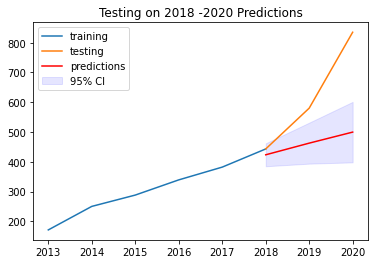

In [112]:
#plotting
pyplot.title('Testing on 2018 -2020 Predictions')
pyplot.plot(df['training'],label='training')
pyplot.plot(df['tesint'],label='testing')
pyplot.plot(df['predictions'], color='red',label='predictions')
pyplot.fill_between(df.index, df['lower'], df['upper'], alpha=0.1, color='b', label="95% CI")
pyplot.legend()
pyplot.show()




In [113]:

#7.1 Grid Search
Parameter=[]
RSME = []


history = [x for x in train]
predictions = list()

p=[1,2]
q=[1,2]
d=[1,2]

warnings.filterwarnings("ignore")

for i1 in p:
  for i2 in q:
    for i3 in d:
      for t in range(len(test)):
	      model = ARIMA(history, order=(i1,i3,i2))
	      model_fit = model.fit()
	      output = model_fit.forecast()
	      yhat = output[0]
	      predictions.append(yhat)
	      obs = test[t]
	      history.append(obs)
	      print('predicted=%f, expected=%f' % (yhat, obs))  
      rmse = sqrt(mean_squared_error(test, predictions))
      parameter=[i1,i3,i2]
      history = [x for x in train]
      predictions = list()  
      RSME.append(rmse)
      Parameter.append(parameter)
      print('Test RMSE: %.3f' % rmse,i1,i3,i2)   
 
dict2= {'RSME':RSME, 'Parameter(p,d,q)':Parameter}
research=pd.DataFrame(dict2)
research.to_csv("Reserch_result.csv",index = False, header = True)

predicted=423.343787, expected=443.000000
predicted=492.818333, expected=580.000000
predicted=679.429953, expected=835.000000
Test RMSE: 103.584 1 1 1
predicted=428.820231, expected=443.000000
predicted=494.654158, expected=580.000000
predicted=723.016565, expected=835.000000
Test RMSE: 81.701 1 2 1
predicted=423.016599, expected=443.000000
predicted=486.447327, expected=580.000000
predicted=687.217009, expected=835.000000
Test RMSE: 101.639 1 1 2
predicted=436.893711, expected=443.000000
predicted=496.561644, expected=580.000000
predicted=696.726504, expected=835.000000
Test RMSE: 93.307 1 2 2
predicted=424.046092, expected=443.000000
predicted=490.838552, expected=580.000000
predicted=711.296628, expected=835.000000
Test RMSE: 88.716 2 1 1
predicted=413.345304, expected=443.000000
predicted=495.051160, expected=580.000000
predicted=680.670438, expected=835.000000
Test RMSE: 103.140 2 2 1
predicted=416.348082, expected=443.000000
predicted=488.872405, expected=580.000000
predicted=689

In [114]:
#7.2 choose best parameter

research= research.sort_values(by= 'RSME')
print("the best parameter is :", research.iloc[0][1])

the best parameter is : [1, 2, 1]


In [149]:
## predict 2021 & 2022

model_7=ARIMA(train_7, order=(1,2,1))
model_fit_7=model.fit()
result=model_fit_7.get_forecast(steps=2)
forecast = result.predicted_mean
ci = result.conf_int(0.05)


print("prediction citation for 2021 is:", int(forecast[0]))
print("prediction citation for 2022 is:", int(forecast[1]))

prediction citation for 2021 is: 688
prediction citation for 2022 is: 808


array([688.30636694, 808.30746593])

In [182]:
year= [pd.to_datetime("2021-01-01"), pd.to_datetime('2022-01-01')]

df2122 = pd.DataFrame({'prediction': forecast,'ci_lower':ci[:,0], 'ci_upper':ci[:,1]}, index=year)

df_7 = pd.concat([train_7[10:],df2122],axis=1)

df_7

,Citation,prediction,ci_lower,ci_upper
2013-01-01,171.0,NaN,NaN,NaN
2014-01-01,250.0,NaN,NaN,NaN
2015-01-01,288.0,NaN,NaN,NaN
2016-01-01,339.0,NaN,NaN,NaN
2017-01-01,382.0,NaN,NaN,NaN
2018-01-01,443.0,NaN,NaN,NaN
2019-01-01,580.0,NaN,NaN,NaN
2020-01-01,835.0,NaN,NaN,NaN
2021-01-01,NaN,688.306367,650.602423,726.010311
2022-01-01,NaN,808.307466,714.358260,902.256671


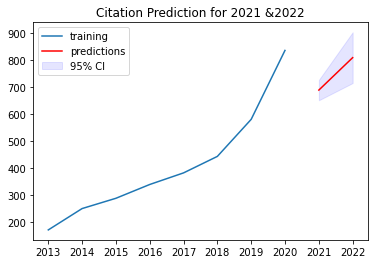

In [183]:
#Plotting
pyplot.title('Citation Prediction for 2021 &2022')
pyplot.plot(df_7['Citation'],label='training')
pyplot.plot(df_7['prediction'], color='red',label='predictions')
pyplot.fill_between(df_7.index, df_7['ci_lower'], df_7['ci_upper'], alpha=0.1, color='b', label="95% CI")
pyplot.legend()
pyplot.show()
